# I. Kalman filter

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# fix the random seed for reproducibility
np.random.seed(7)

## The Algorithm

In [ ]:
class KalmanFilter:
    def __init__(self, F, H, V_epsilon, V_eta, X0, P0):
        """
        Initialize the Kalman Filter .

        Parameters:
        F (np.ndarray): State transition matrix.
        H (np.ndarray): Observation matrix.
        V_epsilon (np.ndarray): Process noise covariance.
        V_eta (np.ndarray): Measurement noise covariance.
        X0 (np.ndarray): Initial state estimate.
        P0 (np.ndarray): Initial covariance estimate.
        """
        try:


            # Convert inputs to numpy arrays

            # Ensure F, H, V_epsilon, V_eta, and P0 are 2-D arrays
            self.F = np.atleast_2d(F)
            self.H = np.atleast_2d(H)
            self.V_epsilon = np.atleast_2d(V_epsilon)
            self.V_eta = np.atleast_2d(V_eta)
            self.P = np.atleast_2d(P0)

            # Ensure X0 is a 1-D array
            self.X = np.atleast_1d(X0)


            # Dimension checks for the inputs to the Kalman Filter
            if self.H.shape[0] != self.V_eta.shape[0]:
                raise ValueError("H and V_eta must have the same number of rows")
            if self.H.shape[1] != self.F.shape[0]:
                raise ValueError("H must have the same number of columns as F")
            if self.V_epsilon.shape[0] != self.F.shape[0]:
                raise ValueError("V_epsilon must have the same number of rows as F")
            if self.X.shape[0] != self.F.shape[0]:
                raise ValueError("X0 must have the same number of rows as F")

            # Square matrices checks for covariance matrices
            if self.V_epsilon.shape[0] != self.V_epsilon.shape[1]:
                raise ValueError("V_epsilon must be a square matrix (process noise covariance)")
            if self.V_eta.shape[0] != self.V_eta.shape[1]:
                raise ValueError("V_eta must be a square matrix (measurement noise covariance)")
            if self.P.shape[0] != self.P.shape[1]:
                raise ValueError("P0 must be a square matrix (covariance)")


        except ValueError as e:
            print(f"Initialization error: {e}. Please check your input.")

    def predict(self, u = None):
        """
        Prediction step of the Kalman Filter (Affine Kalman Filter).

        Parameters:
        u (np.ndarray): Control input.

        Returns:
        np.ndarray: Predicted state estimate.
        np.ndarray: Predicted covariance estimate.
        """
        # Dimension check for control input u
        if u is None:
            u = np.zeros(self.X.shape)  # control input u to = [0,...,0]

        u = np.atleast_1d(u)  # Ensure u is a 1-D array
        if u.shape[0] != self.F.shape[0]:
            raise ValueError("u must have the same number of rows as F")



        # State prediction:
        # X(k) =   F(k) * X(k-1)   + u(k)
        self.X = (self.F @ self.X) + u

        # Covariance prediction:
        #P(k)  =       F(k)* P(k-1) * F(k).T    + V_epsilon(k)
        self.P = ((self.F @ self.P) @ self.F.T) + self.V_epsilon

        return self.X, self.P

    def update(self, Y, h = None):
        """
        Update step of the Kalman Filter (Affine Kalman Filter).

        Parameters:
        Y (np.ndarray): Measurement.
        h (np.ndarray): Control input in Measurement model.

        Returns:
        np.ndarray: corrected state estimate.
        np.ndarray: corrected covariance estimate.
        """
        if h is None:
            h = np.zeros(self.H.shape[0]) # control input u to = [0,...,0]

        # Convert measurement to 1-D array
        h = np.atleast_1d(h)

        # Dimension check for h
        if h.shape[0] != self.H.shape[0]:
            raise ValueError("h must have the same number of rows as H")




        S = (self.H @ self.P @ self.H.T) + self.V_eta

        # Kalman gain:
        # K(k) = P(k) * H(k).T * S(k)^(-1)
        K = (self.P @ self.H.T) @ np.linalg.inv(S)

        # Innovation :
        # I(k) = Y(k) - H(k) * X(k) - h(k)
        I = Y - (self.H @ self.X) - h

        # corrected state estimate:
        # Xk =    X(k)  + K(k) * I(k)
        self.X = self.X + (K @ I)

        # corrected covariance estimate: ( I = identity )
        # P(k) =          (     I        -    K(k) * H(k))  * P(k)
        self.P = (np.eye(self.F.shape[0]) - (K @ self.H)) @ self.P



        return self.X, self.P

# II. Applications

## **II.1. Gaussian random walk**

### Model

1.  Gaussian Random Walk Model

* The system evolves according to a Gaussian random walk process.
* The state at step $n$, denoted as $x_n$, is given by:
$$
        x_n = x_{n-1} + w_n
$$
* Here, $w_t$ is the process noise, which is distributed as: $w_t \sim \mathcal{N}(0, \sigma_w^2)$


2.   Measurement Model


* We observe measurements $y_n$ that are noisy observations of the true state $x_n$.
* The observation at step $n$, denoted as $y_n$, is given by:
$$
        y_n = x_n + v_n
$$
* Here, $v_n$ is the measurement noise, which is distributed as: $v_n \sim \mathcal{N}(0, \sigma_v^2)$

We will consider both a 1D random walk and a 2D random walk.


In [ ]:
def random_walk(X0, steps, sigma_w):
    """
    Generate a random walk sequence.

    Parameters:
    X0 (np.array): Initial state.
    steps (int): Number of steps.
    sigma_w (np.array): Covariance matrix of the process noise.

    Returns:
    np.array: Random walk sequence.
    """

    #add a casting to np.array in case the input is a scalar
    X0 = np.atleast_1d(X0)
    sigma_w = np.atleast_2d(sigma_w)
    assert sigma_w.shape[0] == sigma_w.shape[1], "Covariance matrix must be square"


    dim = X0.shape[0]  # Determine the dimension from the initial state
    # Create X with the same initial value for each dimension
    X = np.zeros((steps + 1, dim)) + X0.reshape(1, -1)


    # Generate the noise for each step
    noise = np.random.multivariate_normal(np.zeros(dim), sigma_w, size=steps)


    # we add the noise cumulatively to the initial value starting from the second step
    X[1:, :] = X0 + np.cumsum(noise, axis=0)


    return X

def random_walk_measurement(X, sigma_v):
    """
    Generate noisy measurements of a random walk.

    Parameters:
    X (np.array): True state sequence.
    sigma_v (np.array): Covariance matrix of the measurement noise.

    Returns:
    np.array: Noisy measurements.
    """

    #add a casting to np.array in case the input is a scalar
    X = np.atleast_2d(X)
    sigma_v = np.atleast_2d(sigma_v)
    assert sigma_v.shape[0] == sigma_v.shape[1], "Covariance matrix must be square"


    dim = X.shape[1]  # Determine the dimension from the initial state
    # Create Y with the same initial value for each dimension

    # Generate the noise for each step
    noise = np.random.multivariate_normal(np.zeros(dim), sigma_v, size=X.shape[0])


    # we add the noise cumulatively to the initial value
    Y = X + noise

    return Y

def ellipse_points(mean, width, height, angle):
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([width*np.cos(t), height*np.sin(t)])
    R_rot = np.array([[np.cos(np.radians(angle)), -np.sin(np.radians(angle))],
                      [np.sin(np.radians(angle)), np.cos(np.radians(angle))]])
    Ell_rot = np.zeros((2, Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:, i] = np.dot(R_rot, Ell[:, i])
    return mean[0] + Ell_rot[0, :], mean[1] + Ell_rot[1, :]



def plot_random_walk(X, Y, X_kf_estimates, P_kf_estimates, ellipse=False):
    if X.shape[1] == 2:  # 2D plotting with Plotly

        n = np.arange(len(Y))
        X_kf_estimates = np.atleast_1d(X_kf_estimates)

        fig = go.Figure()


        fig.add_trace(go.Scatter3d(x=X[:, 0],y=X[:, 1],z=n,mode='lines',
                name='True Value',
                line=dict(color='blue')
            ))

        fig.add_trace(go.Scatter3d(x=Y[:, 0],y=Y[:, 1],z=n,
                mode='markers',
                name='Measurements',
                marker=dict(color='red', opacity=0.8, size=3)
            ))

        fig.add_trace(go.Scatter3d(x=X_kf_estimates[:, 0],y=X_kf_estimates[:, 1],z=n,
                mode='lines',
                name='KF estimate',
                line=dict(color='green')
            ))
        # Add confidence ellipses
        if ellipse == True:
            for i in range(len(X_kf_estimates)):
                mean = X_kf_estimates[i]
                cov = P_kf_estimates[i]
                eigvals, eigvecs = np.linalg.eigh(cov)
                order = eigvals.argsort()[::-1]
                eigvals, eigvecs = eigvals[order], eigvecs[:, order]
                vx, vy = eigvecs[:, 0][0], eigvecs[:, 0][1]
                theta = np.degrees(np.arctan2(vy, vx))
                width, height = 2 * np.sqrt(5.991 * eigvals)  # 95% confidence interval
                ell_x, ell_y = ellipse_points(mean, width, height, theta)




                fig.add_trace(go.Scatter3d(x=ell_x, y=ell_y, z=[n[i]] * len(ell_x), mode='lines',
                                       line=dict(color='rgba(10, 260, 0, 0.3)'), showlegend=False))
                fig.add_trace(go.Scatter3d(x=[mean[0]], y=[mean[1]], z=[n[i]], mode='markers',
                                       marker=dict(color='rgba(10, 260, 0, 0.3)', size=3), showlegend=False))
            fig.add_trace(go.Scatter3d(x=[None], y=[None], z=[None], mode='lines',
                           line=dict(color='rgba(10, 255, 0, 0.3)'), name='ellipse 95%', showlegend=True))

        fig.update_layout(title='2D Random Walk with Kalman Filter Estimates',
                          scene=dict(
                              xaxis_title='X',
                              yaxis_title='Y',
                              zaxis_title='n'
                          ),
                          legend_title='Legend',
                          template='plotly_white')

        fig.show()

    elif X.shape[1] == 1:  # 1D plotting
        Y = Y.flatten()
        X = X.flatten()
        X_kf_estimates = np.atleast_1d(X_kf_estimates)
        P_kf_estimates = np.atleast_1d(P_kf_estimates)
        plt.figure(figsize=(14, 8))
        plt.plot(X, label='True state', color = 'blue')
        plt.scatter(range(len(Y)),Y, label='Measurements', color = 'red', alpha = 0.6, s=15, linestyle='dotted')
        plt.plot(X_kf_estimates, label='Kalman Filter Estimate', color = 'green')
        plt.fill_between(range(len(Y)), X_kf_estimates - 2*np.sqrt(P_kf_estimates), X_kf_estimates + 2*np.sqrt(P_kf_estimates), color='green', alpha=0.3, label='Uncertainty 96%')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('1D Random Walk with Kalman Filter Estimates')
        plt.grid(True)
        plt.show()

    else:
        print("Data dimensionality is not supported for plotting. Please adjust the data or use a different plotting function.")

### 1-dimensional case

In [ ]:
V_epsilon = np.array([[0.1]])
V_eta = np.array([[0.5]])

# Generate the true state
X = random_walk([0], 300, V_epsilon)

# Generate the measurements
Y = random_walk_measurement(X, V_eta)

# Simulation parameters
F = 1
H = 1
X0 = 0
P0 = 0

In [ ]:
kf = KalmanFilter(F, H, V_epsilon, V_eta, X0, P0)

In [ ]:
estimated_states = [X0]
predt_states = []
predt_var = []
P_kf_estimates = [P0]


for i in Y[1:]:
    kf.predict()
    predt_states.append(kf.X.copy())
    predt_var.append(kf.P.copy())
    kf.update(i)
    estimated_states.append(kf.X.copy()[0])
    P_kf_estimates.append(kf.P.copy()[0][0])


In [ ]:
# Compute RMSE between true_states and observations
rmse_observations = compute_rmse(X, Y)

# Compute RMSE between true_states and estimated_states
rmse_estimated = compute_rmse(X.flatten() , np.atleast_2d(estimated_states))

# Compare the RMSEs
print(f"RMSE between true states and observations: {rmse_observations}")
print(f"RMSE between true states and estimated states: {rmse_estimated}")

RMSE between true states and observations: 0.6627377898670813
RMSE between true states and estimated states: 0.4065178260666649


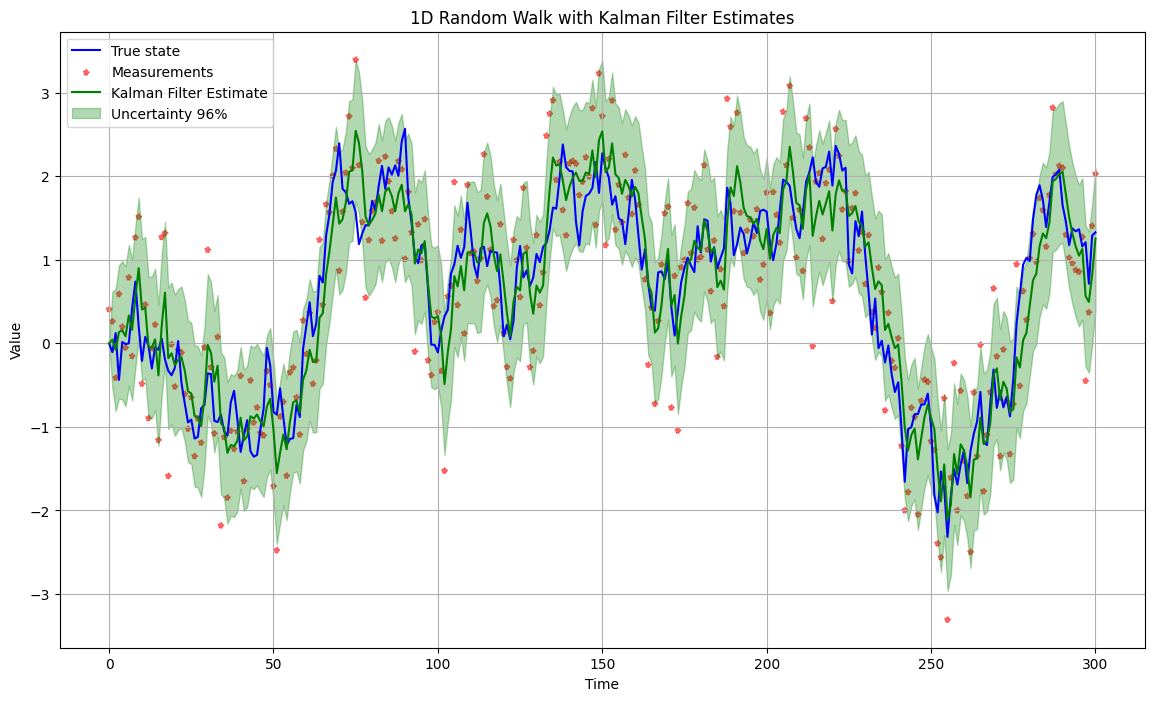

In [ ]:
plot_random_walk(X, Y, estimated_states, P_kf_estimates)

In [ ]:
# Monte Carlo estimate of the proportion within the interval
within_bounds = np.mean((X.flatten() - 2*np.sqrt(P_kf_estimates) < np.atleast_2d(estimated_states)) & (np.atleast_2d(estimated_states) < X.flatten() + 2*np.sqrt(P_kf_estimates)))
print(f"Proportion of estimates within 2 standard deviations of the true state: {round(within_bounds*100, ndigits = 2)} %")

Proportion of estimates within 2 standard deviations of the true state: 96.35 %


### 2-dimensional case

In [ ]:
F = np.eye(2)  # State transition matrix for 2D
H = np.eye(2)  # Observation matrix for 2D
X0 = np.array([0, 0])  # Initial state for 2D
P0 = np.zeros((2, 2))
V_epsilon = np.array([[3,1],[1,3]])
V_eta = np.array([[2,1],[1,2]])

In [ ]:
# Generate the true state
X = random_walk([0, 0], 50, V_epsilon)

# Generate the measurements
Y = random_walk_measurement(X, V_eta)

In [ ]:
kf = KalmanFilter(F, H, V_epsilon, V_eta, X0, P0)

In [ ]:
estimated_states = [X0]
predt_states = []
predt_var = []
P_kf_estimates = [P0]


for i in Y[1:]:
    kf.predict()
    predt_states.append(kf.X.copy())
    predt_var.append(kf.P.copy())
    kf.update(i)
    estimated_states.append(kf.X.copy())
    P_kf_estimates.append(kf.P.copy())

In [ ]:
def compute_rmse(true_values, predicted_values):
    return np.sqrt(np.mean((true_values - predicted_values) ** 2))
# Compute RMSE between true_states and observations
rmse_observations = compute_rmse(X, Y)

# Compute RMSE between true_states and estimated_states
rmse_estimated = compute_rmse(X, estimated_states)

# Compare the RMSEs
print(f"RMSE between true states and observations: {rmse_observations}")
print(f"RMSE between true states and estimated states: {rmse_estimated}")

RMSE between true states and observations: 1.52362349309038
RMSE between true states and estimated states: 1.300513896999119


In [ ]:
plot_random_walk(X, Y, estimated_states, P_kf_estimates)

**Plot with confidence ellipses**

In [ ]:
# Generate the true state
X = random_walk([0, 0], 4, V_epsilon)

# Generate the measurements
Y = random_walk_measurement(X, V_eta)

In [ ]:
estimated_states = [X0]
predt_states = []
predt_var = []
P_kf_estimates = [P0]


for i in Y[1:]:
    kf.predict()
    predt_states.append(kf.X.copy())
    predt_var.append(kf.P.copy())
    kf.update(i)
    estimated_states.append(kf.X.copy())
    P_kf_estimates.append(kf.P.copy())

In [ ]:
plot_random_walk(X, Y, estimated_states, P_kf_estimates,  ellipse=True)

## **II.2. Constant velocity model for car tracking**

The state vector at time step $k$ is:
$$
\mathbf{x}_n = \begin{pmatrix}
x_{1,n} \\
x_{2,n} \\
v_{1,n} \\
v_{2,n}
\end{pmatrix}
$$
where:

* $x_{1,n}$ and $x_{2,n}$ are the positions.
* $v_{1,n}$ and $v_{2,n}$ are the velocities.


The measurement vector at time step $ k $ is:
$$
\mathbf{z}_n = \begin{pmatrix}
z_{1,n} \\
z_{2,n}
\end{pmatrix}
$$
where:
* $ z_{1,n} $ and $ z_{2,n} $ are the measured positions.



1.   Dynamic Model


$$
\mathbf{x}_n = \mathbf{A} \mathbf{x}_{n-1} + \mathbf{q}_{n-1},
$$

$$
\mathbf{q}_{n-1} \sim \mathcal{N}(0, \mathbf{Q})$$ \\

\
\begin{array}{cc}
\mathbf{A} = \begin{pmatrix}
1 & 0 & \Delta t & 0 \\
0 & 1 & 0 & \Delta t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}, &
\quad \mathbf{Q} = \begin{pmatrix}
\frac{q_c^1 \Delta t^3}{3} & 0 & \frac{q_c^1 \Delta t^2}{2} & 0 \\
0 & \frac{q_c^2 \Delta t^3}{3} & 0 & \frac{q_c^2 \Delta t^2}{2} \\
\frac{q_c^1 \Delta t^2}{2} & 0 & q_c^1 \Delta t & 0 \\
0 & \frac{q_c^2 \Delta t^2}{2} & 0 & q_c^2 \Delta t
\end{pmatrix}
\end{array}


2.   Measurement Model

\begin{align}
\mathbf{y}_n &= \mathbf{H} \mathbf{x}_n + \mathbf{r}_n, \quad \mathbf{r}_n \sim \mathcal{N}(0, \mathbf{R}) \\
\mathbf{H} &= \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{pmatrix}, \quad
\mathbf{R} = \begin{pmatrix}
\sigma_1^2 & 0 \\
0 & \sigma_2^2
\end{pmatrix}
\end{align}



In [ ]:
def simulate_states(A, Q, initial_state, num_steps):
    """
    Simulate the state vector X over time

    Parameters:
    A (np.ndarray): State transition matrix.
    Q (np.ndarray): Process noise covariance matrix.
    initial_state (np.ndarray): Initial state vector.
    num_steps (int): Number of time steps to simulate.

    Returns:
    np.ndarray: Array containing all simulated state vectors X_k.
    """
    num_states = initial_state.shape[0]
    X = np.zeros((num_steps, num_states))
    X[0] = initial_state

    for k in range(1, num_steps):
        process_noise = np.random.multivariate_normal(np.zeros(num_states), Q)
        X[k] = A @ X[k-1] + process_noise

    return X

def simulate_measurements(H, R, X):
    """
    Simulate the measurement vector Y over time

    Parameters:
    H (np.ndarray): Observation matrix.
    R (np.ndarray): Measurement noise covariance matrix.
    X (np.ndarray): Array of state vectors X_k.

    Returns:
    np.ndarray: Array containing all simulated measurement vectors Y_k.
    """
    num_steps, n = X.shape
    m = H.shape[0]
    Y = np.zeros((num_steps, m))

    for k in range(num_steps):
        measurement_noise = np.random.multivariate_normal(np.zeros(m), R)
        Y[k] = H @ X[k] + measurement_noise

    return Y

# Model
dt = 1
qc1 = 1
qc2 = 1
sigma2 = 2
sigma1 = 1
X0 = np.array([0, 0, 1, 1])
num_steps = 200

A = np.array([
    [1, 0, dt, 0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
Q = np.array([
    [qc1 * dt**3 / 3, 0, qc1 * dt**2 / 2, 0],
    [0, qc2 * dt**3 / 3, 0, qc2 * dt**2 / 2],
    [qc1 * dt**2 / 2, 0, qc1 * dt, 0],
    [0, qc2 * dt**2 / 2, 0, qc2 * dt]
])


H = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])
R = np.array([
    [sigma1**2, 0],
    [0, sigma2**2]
])

# Simulate states and measurements
X = simulate_states(A, Q, X0, num_steps)
Y = simulate_measurements(H, R, X)

In [ ]:
# Kalman filter
P0 = np.zeros((4,4))

kf = KalmanFilter(A, H, Q, R, X0, P0)

estimated_states = [X0]
predt_states = []
predt_var = []
P_kf_estimates = [P0]


for i in Y[1:]:
    kf.predict()
    predt_states.append(kf.X.copy())
    predt_var.append(kf.P.copy())
    kf.update(i)
    estimated_states.append(kf.X.copy())
    P_kf_estimates.append(kf.P.copy())

estimated_states = np.atleast_1d(estimated_states)

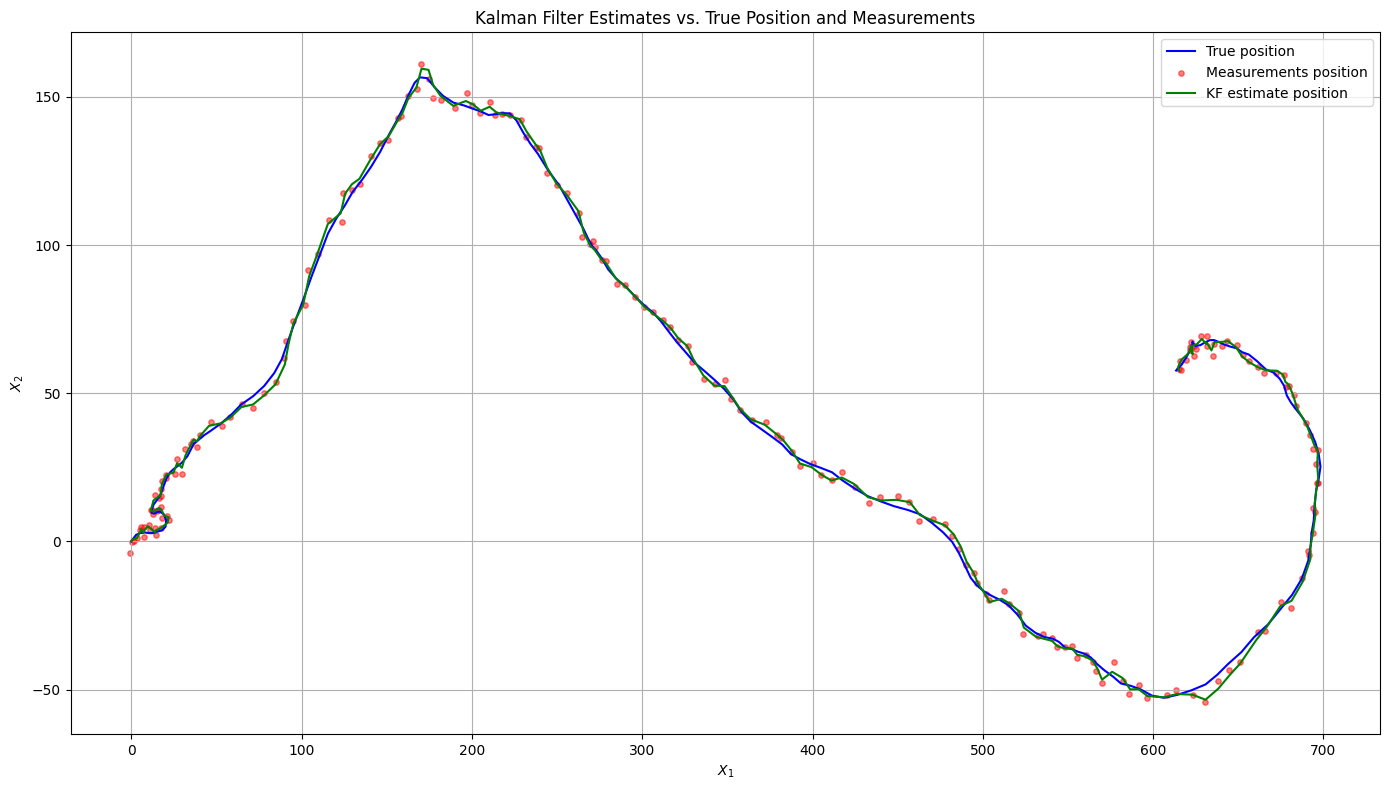

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 8))


plt.plot(X[:, 0], X[:, 1], label='True position', color='blue')
plt.scatter(Y[:, 0], Y[:, 1], label='Measurements position', color='red', s=15, alpha=0.5)
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label='KF estimate position', color='green')

plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Kalman Filter Estimates vs. True Position and Measurements')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def compute_rmse(true_values, predicted_values):
    return np.sqrt(np.mean((true_values - predicted_values) ** 2))
# Compute RMSE between true_states and observations
rmse_observations = compute_rmse(X[:,0:2], Y)


# Compute RMSE between true_states and estimated_states
rmse_estimated = compute_rmse(X[:,0:2], estimated_states[:,0:2])

# Compare the RMSEs
print(f"RMSE between true states and observations: {rmse_observations}")
print(f"RMSE between true states and estimated states: {rmse_estimated}")

RMSE between true states and observations: 1.6406920700982635
RMSE between true states and estimated states: 1.3192083255428515


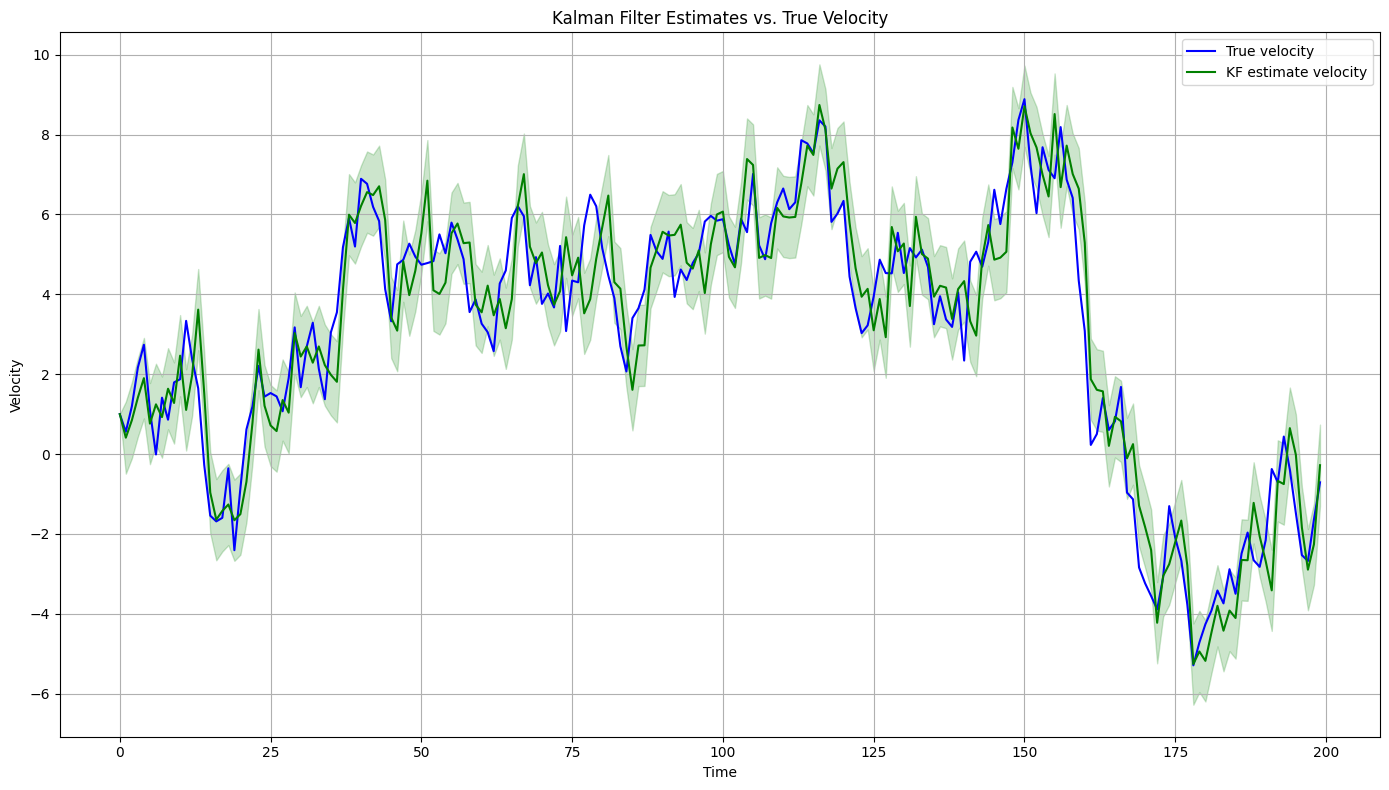

In [ ]:
# Plot the velocity estimates
plt.figure(figsize=(14, 8))

plt.plot(X[:, 2], label='True velocity', color='blue')
plt.plot(estimated_states[:, 2], label='KF estimate velocity', color='green')
plt.fill_between(range(len(estimated_states)), estimated_states[:, 2] - np.sqrt(np.array(P_kf_estimates)[:, 2, 2]), estimated_states[:, 2] + np.sqrt(np.array(P_kf_estimates)[:, 2, 2]), color='green', alpha=0.2)

plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Kalman Filter Estimates vs. True Velocity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Monte Carlo estimate of the proportion within the interval
within_bounds = np.sum(np.abs(X[:, 2] - estimated_states[:, 2]) < 2 * np.sqrt(np.array(P_kf_estimates)[:, 2, 2])) / len(estimated_states)
print(f"Proportion of estimates within 2 standard deviations of the true state: {round(within_bounds*100, ndigits = 2)} %")

Proportion of estimates within 2 standard deviations of the true state: 95.0 %


## **II.3. Pendulum Oscillations**




### Dynamic

We are given the equation for the oscillations of a pendulum:

$$
x''(t) = -\omega^2 x(t),
$$

with initial conditions:

$$
x(0) = 0, \quad x'(0) = 1.
$$

1. **Writing the Equation in Vector Form**

The second-order differential equation can be converted into a first-order system by defining:

$$
z(t) = \begin{pmatrix}
x(t) \\
x'(t)
\end{pmatrix}.
$$

Thus, the system can be written as:

$$
z'(t) = A z(t),
$$

where:

$$
A = \begin{pmatrix}
0 & 1 \\
-\omega^2 & 0
\end{pmatrix}.
$$

The initial condition in vector form is:

$$
z(0) = \begin{pmatrix}
0 \\
1
\end{pmatrix}.
$$

2. **The Solution**

The solution can be expressed as:

$$
z(t) = e^{tA} z(0).
$$

3. **Matrix Exponential Calculation**

Given the matrix  A : $ ω > 0 $

$$
A = \begin{pmatrix}
0 & 1 \\
-\omega^2 & 0
\end{pmatrix}
$$

**Diagonalization**

To diagonalize  A , we solve the characteristic equation:

$$
\text{det}(A - \lambda I) = 0
$$

So, we have:

$$
\begin{vmatrix}
-\lambda & 1 \\
-\omega^2 & -\lambda
\end{vmatrix} = \lambda^2 + \omega^2 = 0
$$

Solving for $ \lambda $, we get:

$$
\lambda = \pm i\omega
$$

**Eigenvectors**

For $ \lambda = i\omega $:

$$
(A - i\omega I) \mathbf{v} = 0
$$

$$
\begin{pmatrix}
-i\omega & 1 \\
-\omega^2 & -i\omega
\end{pmatrix}
\begin{pmatrix}
v_1 \\
v_2
\end{pmatrix} = 0
$$

An eigenvector corresponding to $ \lambda = i\omega $ is:

$$
\mathbf{v_1} = \begin{pmatrix}
\frac{-i}{\omega} \\
1
\end{pmatrix}
$$

For $ \lambda = -i\omega $:

$$
(A + i\omega I) \mathbf{v} = 0
$$

$$
\begin{pmatrix}
i\omega & 1 \\
-\omega^2 & i\omega
\end{pmatrix}
\begin{pmatrix}
v_1 \\
v_2
\end{pmatrix} = 0
$$

An eigenvector corresponding to $ \lambda = -i\omega $ is:

$$
\mathbf{v_2} = \begin{pmatrix}
\frac{i}{\omega} \\
1
\end{pmatrix}
$$

The matrix  P  formed by the eigenvectors and the diagonal matrix  D  are:

$$
P = \begin{pmatrix}
\frac{-i}{\omega} & \frac{i}{\omega} \\
1 & 1
\end{pmatrix}, \quad D = \begin{pmatrix}
i\omega & 0 \\
0 & -i\omega
\end{pmatrix}
$$

**Inverse of  P**

$$
P^{-1} = \begin{pmatrix}
\frac{-\omega}{2i} & \frac{1}{2} \\
\frac{\omega}{2i} & \frac{1}{2}
\end{pmatrix}
$$

Compute $ e^{tA} $

Using the diagonalization, we have:

$$
e^{tA} = P e^{tD} P^{-1}
$$

Since  D  is diagonal, $ e^{tD} $ is simply:

$$
e^{tD} = \begin{pmatrix}
e^{i\omega t} & 0 \\
0 & e^{-i\omega t}
\end{pmatrix}
$$

Thus,

$$
e^{tA} = \begin{pmatrix}
\frac{-i}{\omega} & \frac{i}{\omega} \\
1 & 1
\end{pmatrix}
\begin{pmatrix}
e^{i\omega t} & 0 \\
0 & e^{-i\omega t}
\end{pmatrix}
\begin{pmatrix}
\frac{-\omega}{2i} & \frac{1}{2} \\
\frac{\omega}{2i} & \frac{1}{2}
\end{pmatrix}
$$

**Simplification**

We can simplify the expression:

$$
e^{tA} = \begin{pmatrix}
\frac{e^{i\omega t} + e^{-i\omega t}}{2} & \frac{i(e^{-i\omega t} - e^{i\omega t})}{2\omega} \\
\frac{\omega(e^{-i\omega t} - e^{i\omega t})}{2i} & \frac{e^{i\omega t} + e^{-i\omega t}}{2}
\end{pmatrix}
$$

Using Euler's formulas:

$$
e^{i\omega t} = \cos(\omega t) + i\sin(\omega t)
$$

$$
e^{-i\omega t} = \cos(\omega t) - i\sin(\omega t)
$$

We get:

$$
e^{i\omega t} + e^{-i\omega t} = 2\cos(\omega t)
$$

$$
e^{i\omega t} - e^{-i\omega t} = 2i\sin(\omega t)
$$

Therefore:

$$
e^{tA} = \begin{pmatrix}
\cos(\omega t) & \frac{\sin(\omega t)}{\omega} \\
-\omega \sin(\omega t) & \cos(\omega t)
\end{pmatrix}
$$




### Illustration

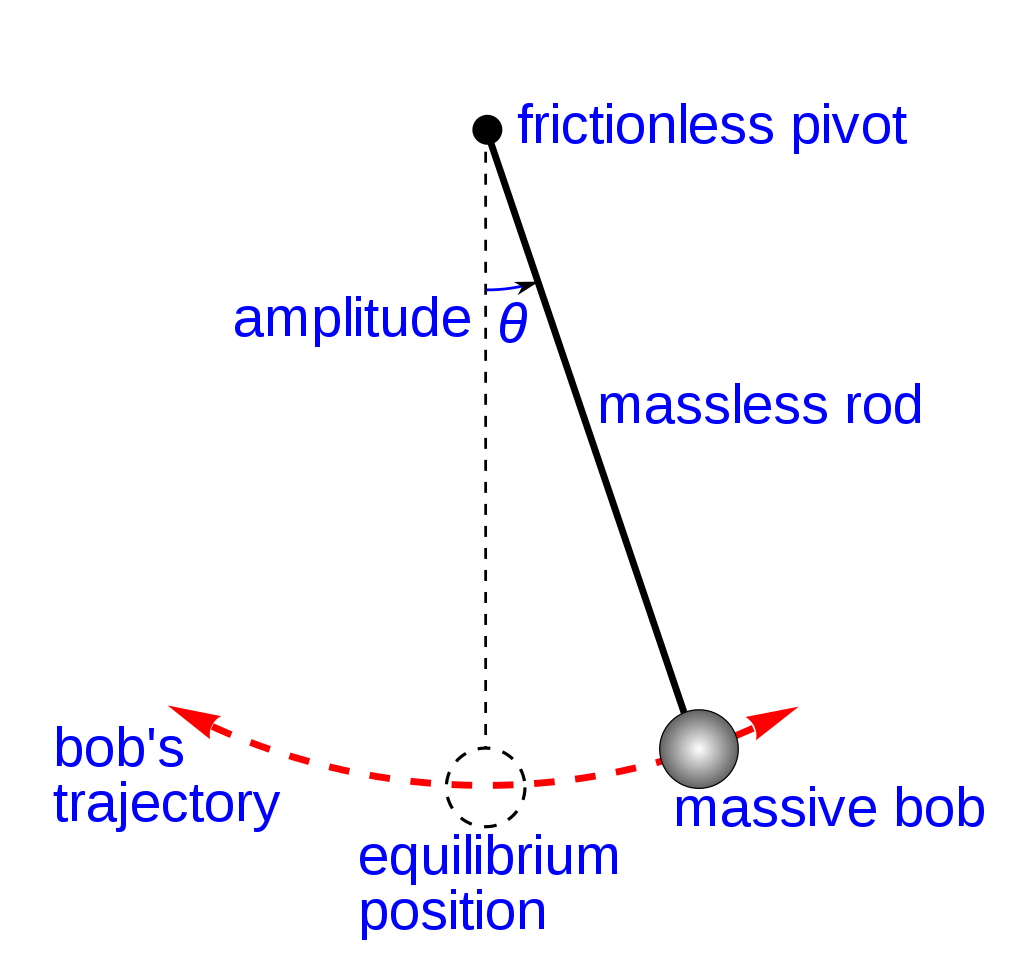

### Model

The dynamical system is defined as:

$$
X_{n+1} = e^{hA} X_n + \epsilon_n
$$

where:

*   $X_{n+1}$ is the state vector at the next time step $n+1$,
*   $X_n$ is the state vector at the current time step $n$, defined as : $$\begin{pmatrix} x_n \\ x'_n \end{pmatrix}$$
*   $\epsilon_k$ is the Gaussian noise vector with mean zero and covariance : $$\begin{pmatrix} \sigma^2 & 0 \\ 0 & \sigma^2 \end{pmatrix}$$


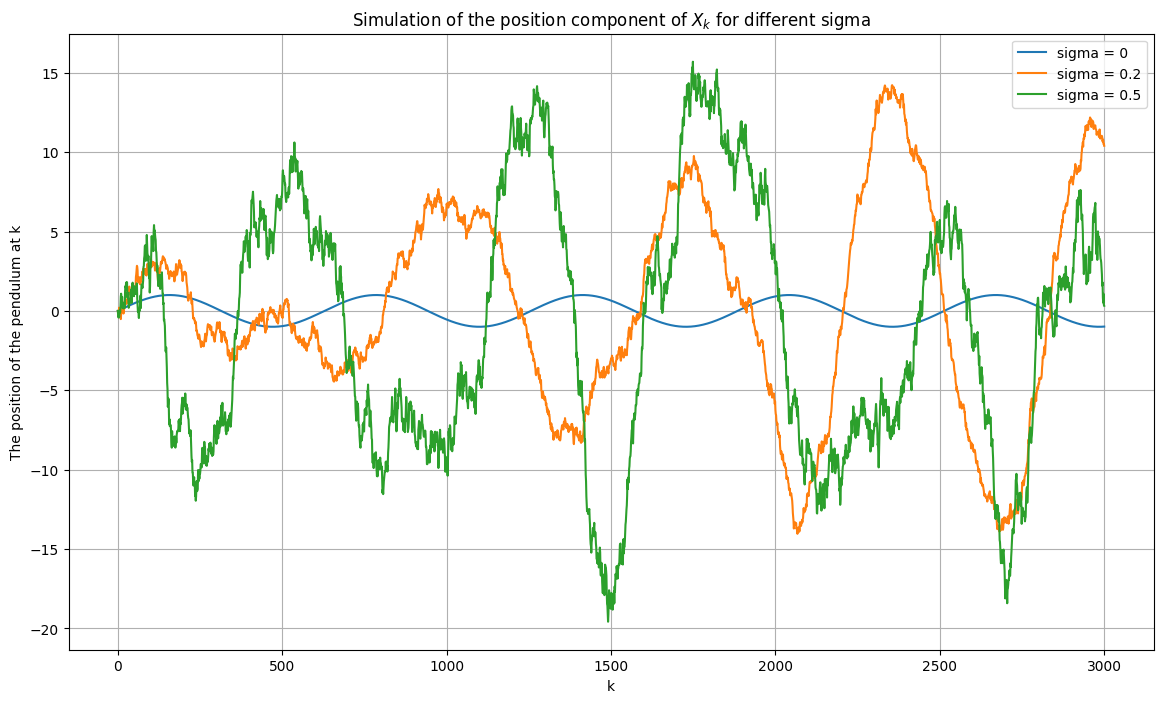

In [ ]:
# Parameters
omega = 1
h = 0.01

# Matrix e^{hA}
exp_hA = np.array([[np.cos(omega * h), np.sin(omega * h) / omega],
                   [-omega * np.sin(omega * h), np.cos(omega * h)]])

def simulate_pendulum(X0, sigma, steps=3000):
    X = np.zeros((steps + 1, 2)) # ( X , X')
    X[0] = X0
    for k in range(steps):
        epsilon_k = np.random.multivariate_normal([0, 0], [[sigma**2, 0], [0, sigma**2]]) #  Process noise
        X[k + 1] = exp_hA @ X[k] + epsilon_k
    return X  #size steps + X0

# Initial condition
X0 = np.array([0, 1])  # x(0) = 0, x'(0) = 1

# Different values of sigma
sigmas = [0, 0.2, 0.5]

# Simulate and plot
plt.figure(figsize=(14, 8))

for sigma in sigmas:
    X = simulate_pendulum(X0, sigma)
    plt.plot(X[:, 0], label=f'sigma = {sigma}')

plt.xlabel('k')
plt.ylabel('The position of the pendulum at k')
plt.title('Simulation of the position component of $X_k$ for different sigma')
plt.legend()
plt.grid(True)
plt.show()



**The phase space**

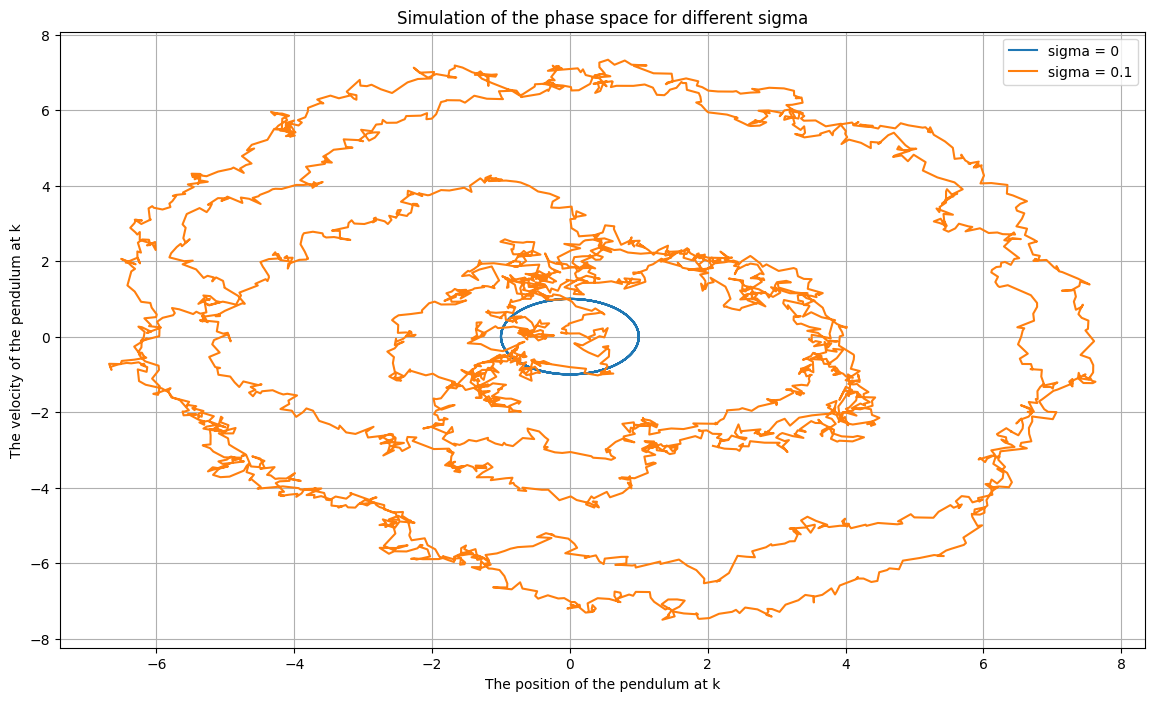

In [ ]:
# The phase space
plt.figure(figsize=(14, 8))

for sigma in [0, 0.1]:
    X = simulate_pendulum(X0, sigma)
    plt.plot(X[:, 0], X[:, 1], label=f'sigma = {sigma}')

plt.xlabel('The position of the pendulum at k')
plt.ylabel('The velocity of the pendulum at k')
plt.title('Simulation of the phase space for different sigma')
plt.legend()
plt.grid(True)
plt.show()

The measurement model is defined as:

$$
Y_n = H \cdot X_n + \eta_n
$$

where:

*  $Y_n$ is the measured position at time step $n$.
*  $H$ is the measurement matrix (we keep only the position), given by:
  $$
  H = \begin{pmatrix}
  1 & 0
  \end{pmatrix}
  $$
* $\eta_n$ is the measurement noise with mean zero and variance $\delta^2$.






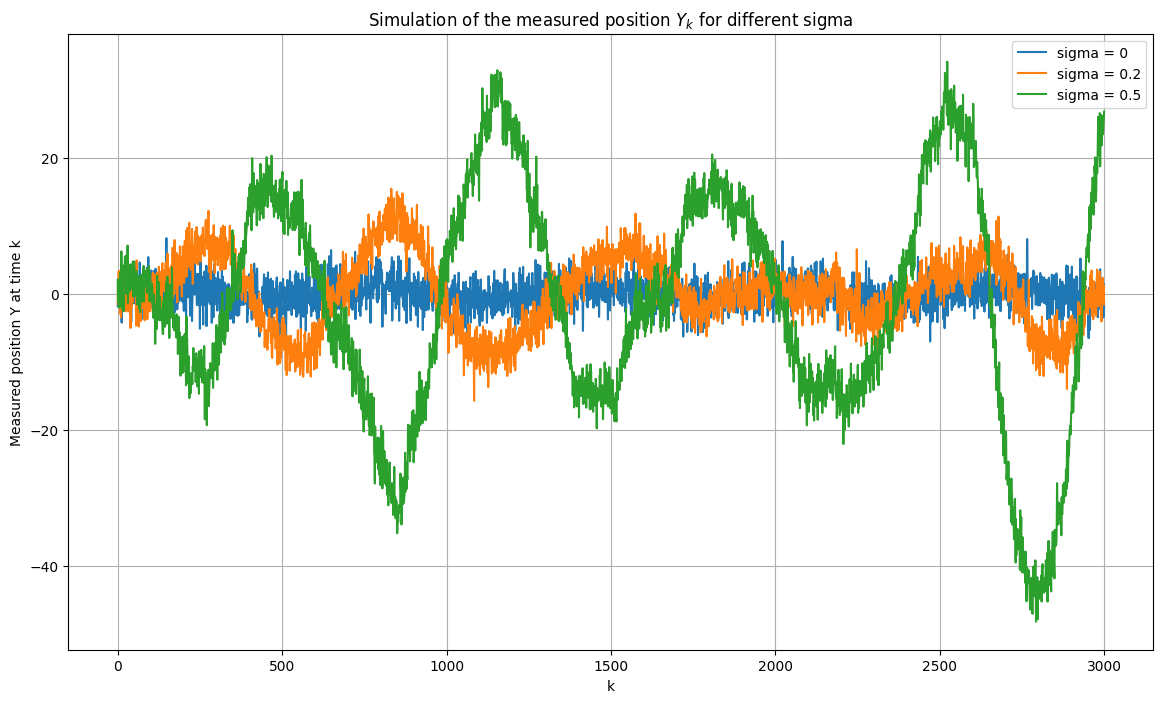

In [ ]:
# Measurement matrix H
H = np.array([1, 0])
# Variance of measurement noise
delta = 2

def simulate_measurements(X, delta, steps=3000):
    Y = np.zeros(steps + 1)
    for k in range(steps + 1):
        eta_k = np.random.normal(0, delta)
        Y[k] = (H @ X[k]).item() + eta_k
    return Y #size steps + 1

# Initial condition
X0 = np.array([0, 1])  # x(0) = 0, x'(0) = 1

# Different values of sigma
sigmas = [0, 0.2, 0.5]

# Simulate and plot
plt.figure(figsize=(14, 8))

for sigma in sigmas:
    X = simulate_pendulum(X0, sigma)
    Y = simulate_measurements(X, delta)
    plt.plot(Y, label=f'sigma = {sigma}')

plt.xlabel('k')
plt.ylabel('Measured position Y at time k')
plt.title('Simulation of the measured position $Y_k$ for different sigma')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define the system parameters
omega = 1
h = 0.01
steps = 5000
sigma = 0.2
delta = 5

# Initial state and covariance estimates for the Kalman Filter
X0_kf = np.array([0, 1])
P0_kf = np.zeros((2, 2)) # deterministic state

X = simulate_pendulum(X0_kf, sigma,steps )
Y = simulate_measurements(X, delta,steps)

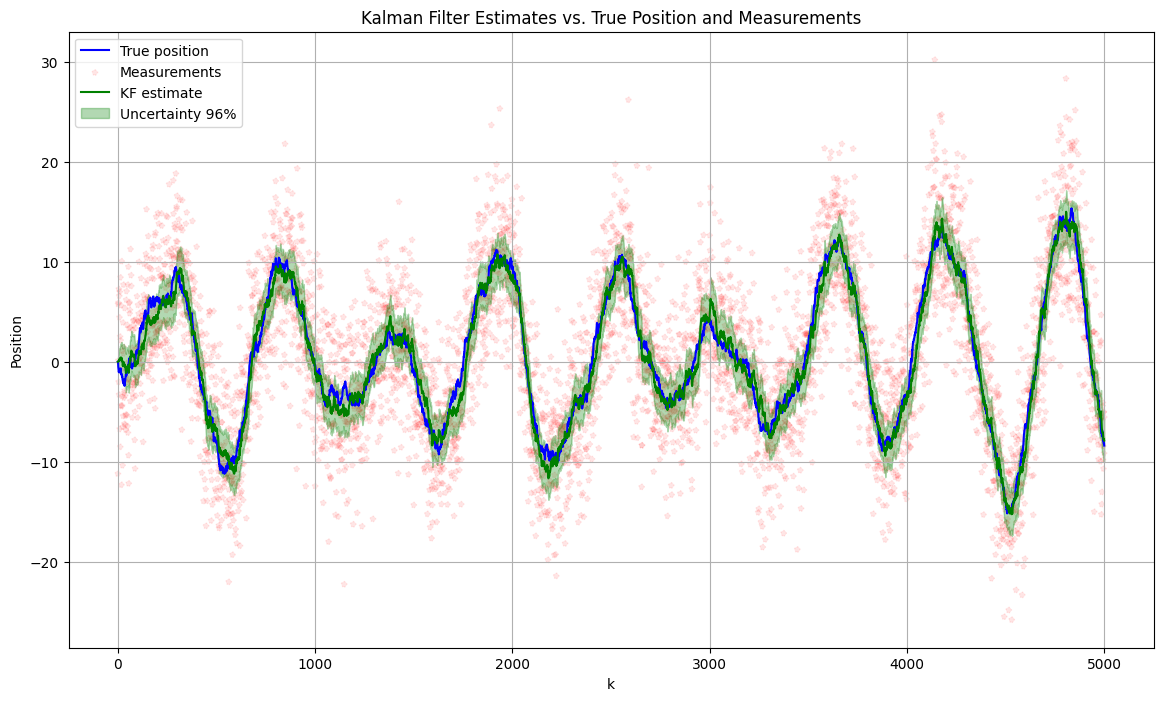

In [ ]:
# Matrix e^{hA}
F = exp_hA
# Measurement matrix H
H = np.array([[1, 0]])

# Variance of measurement noise
V_eta = delta**2

# Variance of Process noise
V_epsilon = sigma**2 * np.identity(2)



kf = KalmanFilter(exp_hA, H, V_epsilon, V_eta, X0_kf, P0_kf)


estimated_states = [X0_kf]
predt_states = []
predt_var = []
P_kf_estimates = [P0_kf]


for i in Y[1:]:
    kf.predict()
    predt_states.append(kf.X.copy())
    predt_var.append(kf.P.copy())
    kf.update(i)
    estimated_states.append(kf.X.copy())
    P_kf_estimates.append(kf.P.copy())

estimated_states = np.atleast_1d(estimated_states)
P_kf_estimates = np.atleast_1d(P_kf_estimates)

plt.figure(figsize=(14, 8))
plt.plot(X[:, 0], label='True position', color = 'blue' )
plt.scatter(range(len(Y)),Y, label='Measurements', linestyle='dotted', alpha = 0.1, color = 'red', s=15)
plt.plot(estimated_states[:, 0], label='KF estimate',  color = 'green')
plt.fill_between(range(len(Y)), estimated_states[:, 0] - 2*np.sqrt(P_kf_estimates[:,0,0]), estimated_states[:, 0] + 2*np.sqrt(P_kf_estimates[:,0,0]), color='green', alpha=0.3, label='Uncertainty 96%')

plt.xlabel('k')
plt.ylabel('Position')
plt.title('Kalman Filter Estimates vs. True Position and Measurements')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Compute RMSE between true_states and observations
rmse_observations = compute_rmse(X[:, 0], Y)

# Compute RMSE between true_states and estimated_states
rmse_estimated = compute_rmse(X[:, 0], X_kf_estimates[:, 0])

# Compare the RMSEs
print(f"RMSE between true states and observations: {rmse_observations}")
print(f"RMSE between true states and estimated states: {rmse_estimated}")


RMSE between true states and observations: 5.064998935172243
RMSE between true states and estimated states: 0.7853929327852471


In [ ]:
# Monte Carlo estimate of the proportion within the interval
within_bounds = np.sum(np.abs(X[:, 0] - estimated_states[:, 0]) < 2 * np.sqrt(np.array(P_kf_estimates)[:, 0, 0])) / len(estimated_states)
print(f"Proportion of estimates within 2 standard deviations of the true state: {round(within_bounds*100, ndigits = 2)} %")

Proportion of estimates within 2 standard deviations of the true state: 93.66 %


In [ ]:
# Compute RMSE between true_states and observations
rmse_observations = compute_rmse(X[:,0], Y)

# Compute RMSE between true_states and estimated_states
rmse_estimated = compute_rmse(X[:,0], estimated_states[:,0])

# Compare the RMSEs
print(f"RMSE between true states and observations: {rmse_observations}")
print(f"RMSE between true states and estimated states: {rmse_estimated}")


RMSE between true states and observations: 4.927057664155184
RMSE between true states and estimated states: 1.112529060411855


# III. Kalman smoother

## The Algorithm

In [ ]:
class KalmanSmoother:

    def __init__(self, F, H, V_epsilon, V_eta, X0, P0):

        """
        Initialize the Rauch-Tung-Striebel Smoother.

        Parameters:
        F (np.ndarray): State transition matrix.
        H (np.ndarray): Observation matrix.
        V_epsilon (np.ndarray): Process noise covariance.
        V_eta (np.ndarray): Measurement noise covariance.
        X0 (np.ndarray): Initial state estimate.
        P0 (np.ndarray): Initial covariance estimate.
        """
        try:

            # Convert inputs to numpy arrays

            # Ensure F, H, V_epsilon, V_eta, and P0 are 2-D arrays
            self.F = np.atleast_2d(F)
            self.H = np.atleast_2d(H)
            self.V_epsilon = np.atleast_2d(V_epsilon)
            self.V_eta = np.atleast_2d(V_eta)
            self.P = np.atleast_2d(P0)

            # Ensure X0 is a 1-D array
            self.X = np.atleast_1d(X0)

            # Dimension checks for the inputs to the Kalman Filter
            if self.H.shape[0] != self.V_eta.shape[0]:
                raise ValueError("H and V_eta must have the same number of rows")
            if self.H.shape[1] != self.F.shape[0]:
                raise ValueError("H must have the same number of columns as F")
            if self.V_epsilon.shape[0] != self.F.shape[0]:
                raise ValueError("V_epsilon must have the same number of rows as F")
            if self.X.shape[0] != self.F.shape[0]:
                raise ValueError("X0 must have the same number of rows as F")

            # Square matrices checks for covariance matrices
            if self.V_epsilon.shape[0] != self.V_epsilon.shape[1]:
                raise ValueError("V_epsilon must be a square matrix (process noise covariance)")
            if self.V_eta.shape[0] != self.V_eta.shape[1]:
                raise ValueError("V_eta must be a square matrix (measurement noise covariance)")
            if self.P.shape[0] != self.P.shape[1]:
                raise ValueError("P0 must be a square matrix (covariance)")

        except ValueError as e:
            print(f"Initialization error: {e}. Please check your input.")

    def smooth(self, estimated_states, P_kf_estimates):
        """
        Rauch-Tung-Striebel Smoother.

        Parameters:
        estimated_states (np.ndarray): Estimated states from the Kalman Filter.
        P_kf_estimates (np.ndarray): Covariance estimates from the Kalman Filter.

        Returns:
        np.ndarray: Smoothed state estimates.
        np.ndarray: Smoothed covariance estimates.
        """
        # Ensure estimated_states and P_kf_estimates are 2-D arrays
        estimated_states = np.atleast_2d(estimated_states)
        P_kf_estimates = np.atleast_3d(P_kf_estimates)

        # Initialize the smoothed state and covariance estimates
        smoothed_states = np.zeros_like(estimated_states)
        smoothed_covariances = np.zeros_like(P_kf_estimates)

        # Initialize the last state and covariance estimates
        smoothed_states[-1] = estimated_states[-1]
        smoothed_covariances[-1] = P_kf_estimates[-1]

        # Initialize the smoother gain
        J = np.zeros_like(P_kf_estimates)

        for k in range(len(estimated_states) - 2, -1, -1):
            # Compute the smoother gain :  J_{k} = P_{k|k} * F_k^T  *P_ {k+1|k}^{-1}
            J[k] = P_kf_estimates[k] @ self.F.T @ np.linalg.inv(self.F @ P_kf_estimates[k] @ self.F.T + self.V_epsilon)

            # Compute the smoothed state estimate : {X}_{k|n}      = {X}_{k|k} +  J_k  *   ({X}_{k+1|n} - {X}_{k+1|k})
            smoothed_states[k] = estimated_states[k] + J[k] @ (smoothed_states[k + 1] - self.F @ estimated_states[k])

            # Compute the smoothed covariance estimate : {P}_{k|n}      = {P}_{k|k} +  J_k  *     ({P}_{k+1|n} - {P}_{k+1|k})    * J_k^T
            smoothed_covariances[k] = P_kf_estimates[k] + J[k] @ (smoothed_covariances[k + 1] - self.F @ P_kf_estimates[k] @ self.F.T) @ J[k].T

        return smoothed_states, smoothed_covariances




# IV. Applications

In [ ]:
# basic application of the Rauch-Tung-Striebel Smoother
# model parameters for a 1D random walk
F = np.array([[1]])
H = np.array([[1]])
V_epsilon = np.array([[1]])
V_eta = np.array([[4]])
X0 = np.array([0])
P0 = np.array([[0]])

# generate the true state
X = random_walk([0], 50, V_epsilon)

# generate the measurements

Y = random_walk_measurement(X, V_eta)

kf = KalmanFilter(F, H, V_epsilon, V_eta, X0, P0)

estimated_states = [X0]
predt_states = []
predt_var = []
P_kf_estimates = [P0]

for i in Y[1:]:
    kf.predict()
    predt_states.append(kf.X.copy())
    predt_var.append(kf.P.copy())
    kf.update(i)
    estimated_states.append(kf.X.copy())
    P_kf_estimates.append(kf.P.copy())

estimated_states = np.atleast_1d(estimated_states)
P_kf_estimates = np.atleast_3d(P_kf_estimates)

rts_smoother = KalmanSmoother(F, H, V_epsilon, V_eta, X0, P0)

smoothed_states, smoothed_covariances = rts_smoother.smooth(estimated_states, P_kf_estimates)

In [ ]:
def compute_rmse(true_values, predicted_values):
    return np.sqrt(np.mean((true_values - predicted_values) ** 2))

# The RMSE between true_states and smoothed_states
rmse_smoothed = compute_rmse(X, smoothed_states)
print(f"RMSE between true states and smoothed states: {rmse_smoothed}")

# The RMSE between true_states and filtered_states
rmse_filtered = compute_rmse(X, estimated_states)
print(f"RMSE between true states and filtered states: {rmse_filtered}")

# The RMSE between true_states and observations
rmse_observations = compute_rmse(X, Y)
print(f"RMSE between true states and observations: {rmse_observations}")



RMSE between true states and smoothed states: 0.6514615811714017
RMSE between true states and filtered states: 0.9923240626554837
RMSE between true states and observations: 2.020384602267745


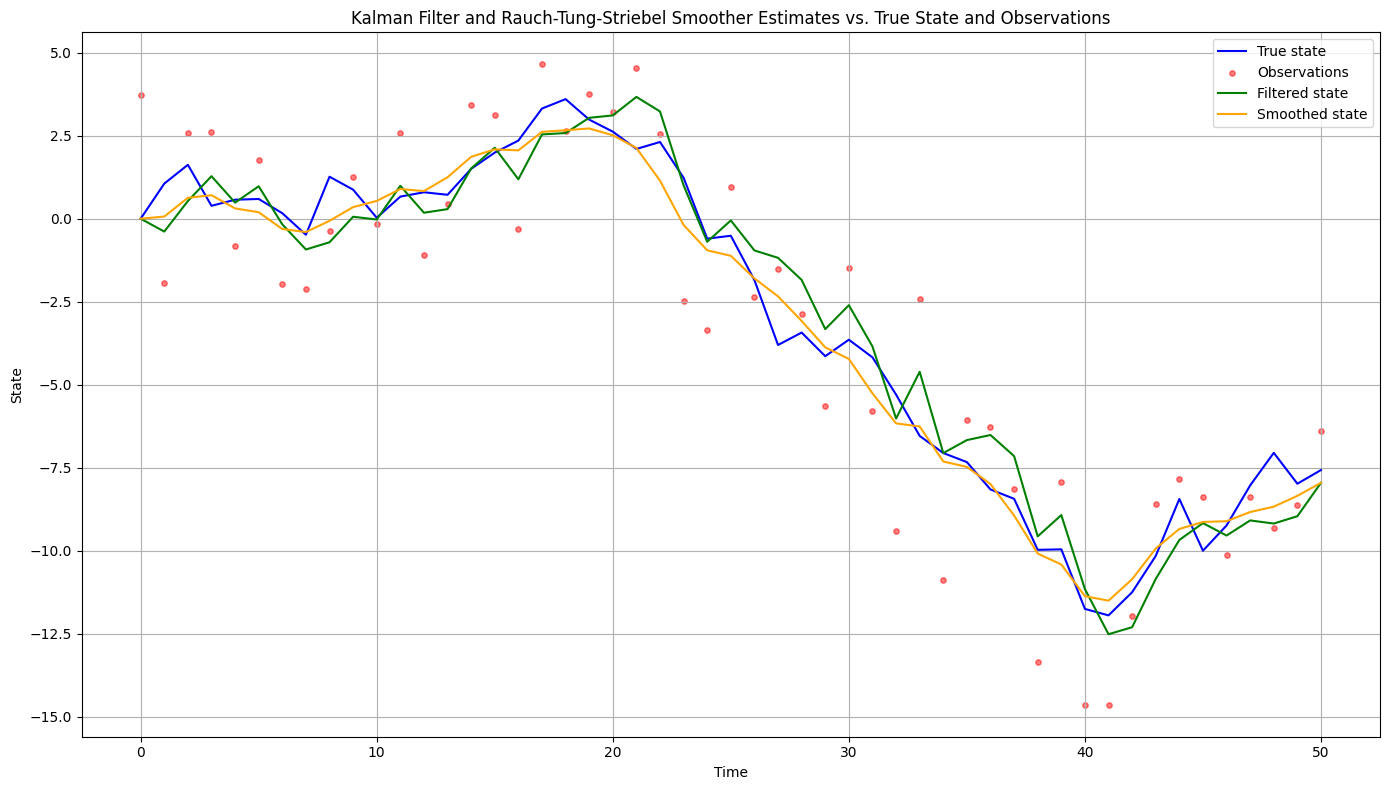

In [ ]:
#plot the results the smoothed states vs the true states vs the observations vs the filtered states
plt.figure(figsize=(14, 8))

plt.plot(X, label='True state', color='blue')
plt.scatter(np.arange(len(Y)), Y, label='Observations', color='red', s=15, alpha=0.5)
plt.plot(estimated_states, label='Filtered state', color='green')
plt.plot(smoothed_states, label='Smoothed state', color='orange')

plt.xlabel('Time')
plt.ylabel('State')
plt.title('Kalman Filter and Rauch-Tung-Striebel Smoother Estimates vs. True State and Observations')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



# V. References



1. Guillaume Cebron et Manon Costa. « Modèle gaussien : le filtre de Kalman ». Simulations stochastiques, 2020-2021.

2. Simo Särkkä and Lennart Svensson. *Bayesian Filtering and Smoothing*. Cambridge University Press, second edition, 2023.
